# Bringing In The Dataset

In [2]:
import pandas as pd
import numpy as np
import sklearn
import json
import plotly.express as px

In [40]:
foods_train_path = r"C:\Users\joe\Datasets\Foods_train.txt"
with open (foods_train_path, "r")  as data:
    json_data = data.read()
data = json.loads(json_data)
df = pd.DataFrame(data)

In [41]:
df.head()

,id,cuisine,ingredients
0,10259,greek,"[romaine lettuce, black olives, grape tomatoes..."
1,25693,southern_us,"[plain flour, ground pepper, salt, tomatoes, g..."
2,20130,filipino,"[eggs, pepper, salt, mayonaise, cooking oil, g..."
3,22213,indian,"[water, vegetable oil, wheat, salt]"
4,13162,indian,"[black pepper, shallots, cornflour, cayenne pe..."


# Making Observations On The Dataset

In [42]:
# Dimensions of the dataset
df.shape

(39774, 3)

In [43]:
# Datatypes of the columns
df.dtypes

id              int64
cuisine        object
ingredients    object
dtype: object

In [44]:
print("Number of unique cuisines:", len(df["cuisine"].unique()))
df["cuisine"].unique()

Number of unique cuisines: 20


array(['greek', 'southern_us', 'filipino', 'indian', 'jamaican',
       'spanish', 'italian', 'mexican', 'chinese', 'british', 'thai',
       'vietnamese', 'cajun_creole', 'brazilian', 'french', 'japanese',
       'irish', 'korean', 'moroccan', 'russian'], dtype=object)

In [45]:
# Checking for missing values
df.isnull().sum()

id             0
cuisine        0
ingredients    0
dtype: int64

In [46]:
# Ingredients of first dish
df["ingredients"][0]

['romaine lettuce',
 'black olives',
 'grape tomatoes',
 'garlic',
 'pepper',
 'purple onion',
 'seasoning',
 'garbanzo beans',
 'feta cheese crumbles']

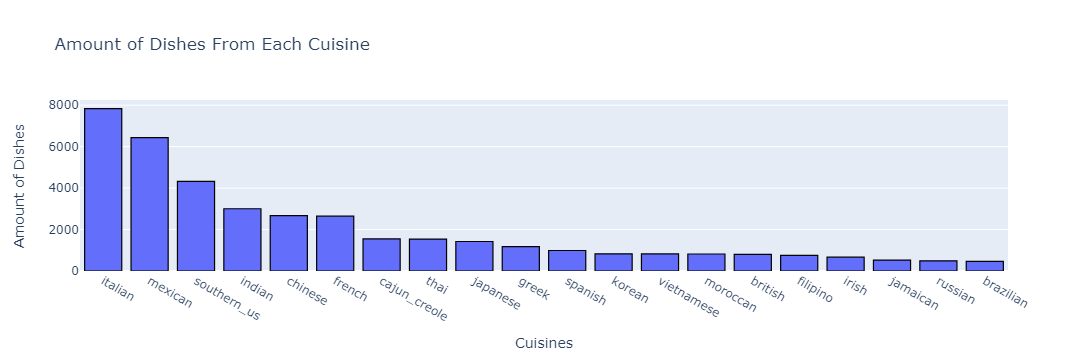

In [187]:
# Making a dataframe of the amount of dishes from each cuisine
dishes_count = pd.DataFrame(df.groupby("cuisine")["cuisine"].count().sort_values(ascending=False))

fig = px.histogram(dishes_count, x=dishes_count.index, y=dishes_count["cuisine"], title="Amount of Dishes From Each Cuisine",
                   labels={"index":"Cuisine"})
fig.for_each_trace(lambda t: t.update(hovertemplate=t.hovertemplate.replace("sum of cuisine", "Count"))) # To replace the title in the hover template
fig.update_traces(marker_line_width=1.2, marker_line_color="black")
fig.update_layout(xaxis_title="Cuisines", yaxis_title="Amount of Dishes")
fig

# Data Cleaning

For this project the id column will not be necessary, so I will drop it

In [48]:
df.drop("id", axis=1, inplace=True)
df.head()

,cuisine,ingredients
0,greek,"[romaine lettuce, black olives, grape tomatoes..."
1,southern_us,"[plain flour, ground pepper, salt, tomatoes, g..."
2,filipino,"[eggs, pepper, salt, mayonaise, cooking oil, g..."
3,indian,"[water, vegetable oil, wheat, salt]"
4,indian,"[black pepper, shallots, cornflour, cayenne pe..."


The main goal of this data cleaning is getting all the ingredients one-hot encoded to be able to train a model on them. 
The first step is to expand the ingredients column to get the ingredients out of the lists

In [89]:
expanded_df = pd.DataFrame(df["ingredients"].apply(pd.Series))
print("Dimensions of dataframe", expanded_df.shape)
expanded_df.head()

Dimensions of dataframe (39774, 65)


,0,1,2,3,4,5,6,7,8,9,...,55,56,57,58,59,60,61,62,63,64
0,romaine lettuce,black olives,grape tomatoes,garlic,pepper,purple onion,seasoning,garbanzo beans,feta cheese crumbles,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,plain flour,ground pepper,salt,tomatoes,ground black pepper,thyme,eggs,green tomatoes,yellow corn meal,milk,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,eggs,pepper,salt,mayonaise,cooking oil,green chilies,grilled chicken breasts,garlic powder,yellow onion,soy sauce,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,water,vegetable oil,wheat,salt,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,black pepper,shallots,cornflour,cayenne pepper,onions,garlic paste,milk,butter,salt,lemon juice,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


The next step is to apply one-hot encoding to the expanded dataframe

In [90]:
expanded_df = pd.get_dummies(expanded_df, prefix="", prefix_sep="")
print("Dimensions of dataframe", expanded_df.shape)

Dimensions of dataframe (39774, 43963)


There are a lot of duplicate ingredients in the one-hot encoded dataframe. This can be dealt with by grouping the columns 
based on sum because if a dish has a certain ingredient, a 1 will only show up in one of the duplicates. Before doing this, the
dataframe must be split smaller pieces to be more manageable

In [91]:
# Splitting the dataset
split_df_list = []
x = int(len(expanded_df.index) / 21)
for num in range(21):
    split_df = expanded_df.iloc[num*x : (num+1)*x, :]
    split_df_list.append(split_df)

Now the idea is to apply the grouping to each piece of the dataframe, then concatenate them to form a new dataframe with the 
same number of rows but less columns

In [95]:
# Grouping the ingredients for each dataframe in the list
for i in range(len(split_df_list)):
    split_df_list[i] = split_df_list[i].groupby(split_df_list[i].columns, axis=1).sum()   
# Concatenating the pieces
expanded_df = pd.concat(split_df_list, axis=0)

The last step is to add back the "cuisine" column

In [100]:
cuisine = pd.DataFrame(df["cuisine"])
expanded_df = pd.concat([cuisine, expanded_df], axis=1)
print("New Dimensions of dataframe:", expanded_df.shape)
expanded_df.head()

New Dimensions of dataframe: (39774, 6715)


,cuisine,( oz.) tomato sauce,( oz.) tomato paste,(10 oz.) frozen chopped spinach,"(10 oz.) frozen chopped spinach, thawed and squeezed dry",(14 oz.) sweetened condensed milk,(14.5 oz.) diced tomatoes,(15 oz.) refried beans,1% low-fat buttermilk,1% low-fat chocolate milk,...,yukon gold potatoes,yuzu,yuzu juice,za'atar,zest,zesty italian dressing,zinfandel,ziti,zucchini,zucchini blossoms
0,greek,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,southern_us,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,filipino,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,indian,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,indian,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


There are lots of very specific ingredients in the dataframe. It could be useful to take out ingredients that are not used
a much. I will make a separate dataframe with only ingredients that are used 5 or more times

In [155]:
# Dropping the cuisine column for now, it will be added back later
expanded_df2 = expanded_df.drop("cuisine", axis=1)
expanded_df2 = expanded_df2.loc[:, expanded_df2.sum(axis=0) >=5]
expanded_df2 = pd.concat([cuisine, expanded_df2], axis=1) # Adding back cuisine column
expanded_df2.head()

,cuisine,( oz.) tomato sauce,( oz.) tomato paste,1% low-fat cottage cheese,1% low-fat milk,2% low-fat cottage cheese,2% reduced-fat milk,40% less sodium taco seasoning,40% less sodium taco seasoning mix,Accent Seasoning,...,yoghurt,yolk,yukon gold,yukon gold potatoes,yuzu,zest,zesty italian dressing,zinfandel,ziti,zucchini
0,greek,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,southern_us,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,filipino,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,indian,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,indian,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


# EDA

The dataframe is in the format I want. Now it's time to do exploratory data analysis. Some questions to be answered are:
* Which cuisines use the most ingredients per dish on average?
* How many ingredients are used across a certain number of cuisines?
* For each cuisine, what are the most used ingredients?
* For a certain ingredient or group of ingredients, which cuisines use it thet most?

### Cuisines With Most Ingredients Per Dish On Average

In [158]:
# ingredients_count_df will have one column with the cuisine and one with the amount of ingredients in the dish
ingredients_count = pd.DataFrame(expanded_df.sum(axis=1))
ingredients_count_df = pd.concat([expanded_df["cuisine"], ingredients_count], axis=1)
ingredients_count_df.head()

C:\Users\joe\AppData\Local\Temp\ipykernel_17896\2712273125.py:2: FutureWarning:

Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.



,cuisine,0
0,greek,9
1,southern_us,11
2,filipino,12
3,indian,4
4,indian,20


In [167]:
# Statistical summary
ingredients_count_df.describe()

,0
count,39774.000000
mean,10.767713
std,4.428978
min,1.000000
25%,8.000000
50%,10.000000
75%,13.000000
max,65.000000


In [169]:
# Now groupby can be used to find the average count in each cuisine
ingredients_count_df.groupby("cuisine")[0].mean().sort_values(ascending=False).round(2)

cuisine
moroccan        12.91
indian          12.71
vietnamese      12.68
cajun_creole    12.62
thai            12.55
jamaican        12.21
chinese         11.98
korean          11.28
mexican         10.88
spanish         10.42
russian         10.22
greek           10.18
filipino        10.00
italian          9.91
french           9.82
japanese         9.74
british          9.71
southern_us      9.63
brazilian        9.52
irish            9.30
Name: 0, dtype: float64

This tells us the Moroccan, Indian, and Vietnamese cuisines use the most ingredients per dish on average

### Histogram For Amount Of Ingredients Per Dish

This is an extension of the previous topic, and ingredients_count_df can be used

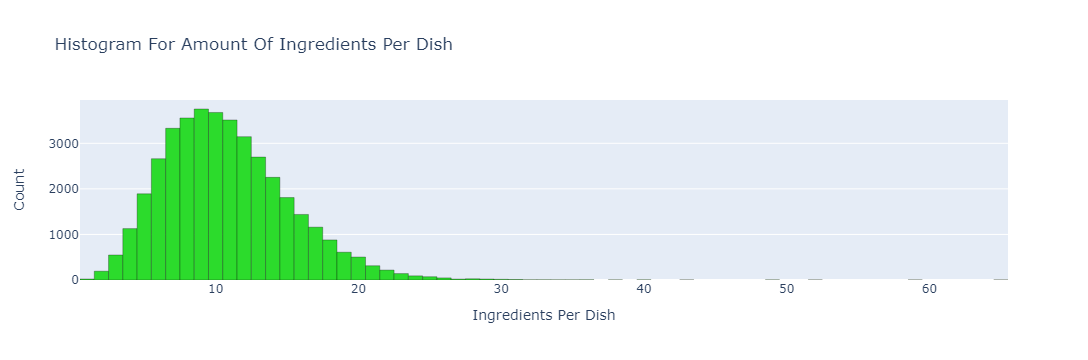

In [185]:
fig = px.histogram(ingredients_count_df, x=0, title="Histogram For Amount Of Ingredients Per Dish", labels={"0": "Ingredients"},
                   color_discrete_sequence=["#2cdb2c"])
fig.update_layout(xaxis_title="Ingredients Per Dish", yaxis_title="Count")
fig.update_traces(marker_line_width=0.3, marker_line_color="black")
fig